In [1]:
from quadmodel.inference.forward_model import forward_model
import os
import numpy as np
import matplotlib.pyplot as plt

### Forward modeling image flux ratios with quadmodel

In the following cell, we define the parameters we want to sample in the forward model, and set the lens data class

In [2]:
output_path = os.getcwd() + '/example_inference_output/'
job_index = 1
n_keep = 4
summary_statistic_tolerance = 1e4
lens_data = 'B1422'
from quadmodel.data.b1422 import B1422
lens_data = B1422(macromodel_type='EPL_FREE_SHEAR_MULTIPOLE_34')
print(lens_data.m)
print(lens_data.macromodel_type)
realization_priors = {}
realization_priors['PRESET_MODEL'] = 'WDM'
realization_priors['log10_sigma_sub'] = ['UNIFORM', -2.0, -1.0]
realization_priors['LOS_normalization'] = ['FIXED', 1.]
realization_priors['log_mc'] = ['UNIFORM', 8.0, 10.0]
realization_priors['log_m_host'] = ['FIXED', 13.3]

macromodel_priors = {}
macromodel_priors['m4_amplitude_prior'] = [np.random.normal, 0.0, 0.01]
macromodel_priors['m3_amplitude_prior'] = [np.random.normal, 0.0, 0.005]
macromodel_priors['gamma_macro_prior'] = [np.random.uniform, 1.9, 2.2]

# FOR A CUSTOM SHEAR PRIOR:
# macromodel_priors['shear_strength_prior'] = [np.random.uniform, 0.05, 0.25]

# the present lenses also have built-in shear priors determined based on what values get accepted after running ABC;
# using a brooader prior, you will waste some time exploring parameter space that will get rejected
# shear_min, shear_max = lens_data.kwargs_macromodel['shear_amplitude_min'], lens_data.kwargs_macromodel['shear_amplitude_max']
# print(shear_min, shear_max)
# macromodel_priors['shear_strength_prior'] = [np.random.uniform, shear_min, shear_max]


[0.88  1.    0.474 0.025]
EPL_FREE_SHEAR_MULTIPOLE_34


### Run the simulation

reading output to files: 
/Users/danielgilman/Code/quadmodel/notebooks/example_inference_output/job_1/parameters.txt
/Users/danielgilman/Code/quadmodel/notebooks/example_inference_output/job_1/fluxes.txt
starting with 0 samples accepted, 4 remain
existing magnifications:  None
samples remaining:  4
running simulation with a summary statistic tolerance of:  10000.0
importance weight for sample:  1.0
sample (from realization samples):  [-1.97823264  9.83850516]
realization contains 1 halos.
['log10_sigma_sub', 'log_mc']
realization hyper-parameters:  [-1.97823264  9.83850516]
['source_size_pc']
source/lens parameters:  31.336819953134246
['a_m_3', 'a_m_4', 'd_phi_a3', 'gamma_macro']
macromodel samples:  [0.00569355 0.00614484 0.58562389 2.03307936]


keyword arguments for realization: 
preset model function:  <function WDM at 0x7fab8b440820>
kwargs preset model:  {'sigma_sub': 0.010513985261584955, 'LOS_normalization': 1.0, 'log_mc': 9.8385051577867, 'log_m_host': 13.3, 'cone_opening_ang

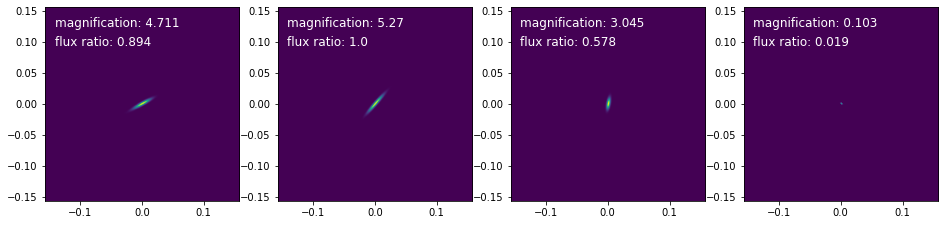

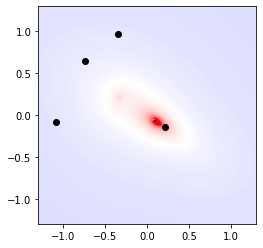

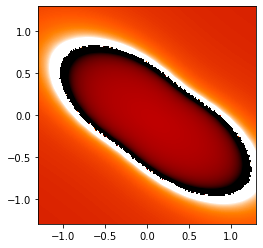

continue
flux ratios data:  [1.1363636363636365, 0.5386363636363636]
flux ratios model:  [1.1401619150693396, 0.654677338087154]
statistic:  0.11610312085648342
N_kept:  1
N remaining:  3
accepted realizations counter:  1
readout steps:  2
importance weight for sample:  1.0
sample (from realization samples):  [-1.75353392  8.08354517]
realization contains 56 halos.
['log10_sigma_sub', 'log_mc']
realization hyper-parameters:  [-1.75353392  8.08354517]
['source_size_pc']
source/lens parameters:  49.78062737242046
['a_m_3', 'a_m_4', 'd_phi_a3', 'gamma_macro']
macromodel samples:  [-4.13338163e-04 -7.35683704e-03  7.94061576e-01  2.07290990e+00]


keyword arguments for realization: 
preset model function:  <function WDM at 0x7fab8b440820>
kwargs preset model:  {'sigma_sub': 0.01763868014204176, 'LOS_normalization': 1.0, 'log_mc': 8.083545171854677, 'log_m_host': 13.3, 'cone_opening_angle_arcsec': 3.8832270661274713}
optimization 1
aperture size (front):  100
aperture size (back):  100
log1

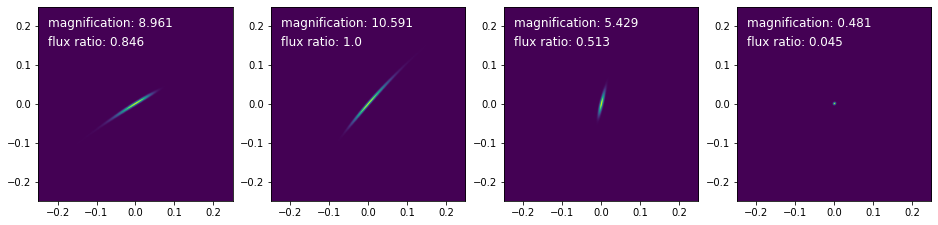

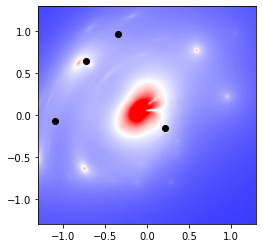

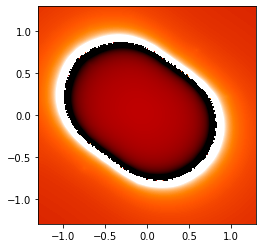

continue
flux ratios data:  [1.1363636363636365, 0.5386363636363636]
flux ratios model:  [1.1656843415474831, 0.6021217676574155]
statistic:  0.0699292519350397
N_kept:  2
N remaining:  2
accepted realizations counter:  2
readout steps:  2
reading out data on this iteration.
writing parameter output to /Users/danielgilman/Code/quadmodel/notebooks/example_inference_output/job_1/parameters.txt
writing flux ratio output to /Users/danielgilman/Code/quadmodel/notebooks/example_inference_output/job_1/fluxes.txt
writing macromodel samples to /Users/danielgilman/Code/quadmodel/notebooks/example_inference_output/job_1/macromodel_samples.txt
writing kappa/gamma statistics to /Users/danielgilman/Code/quadmodel/notebooks/example_inference_output/job_1/kappa_gamma_statistics.txt
writing curved arc statistics to /Users/danielgilman/Code/quadmodel/notebooks/example_inference_output/job_1/curvedarc_statistics.txt
writing curved arc statistics to /Users/danielgilman/Code/quadmodel/notebooks/example_inf

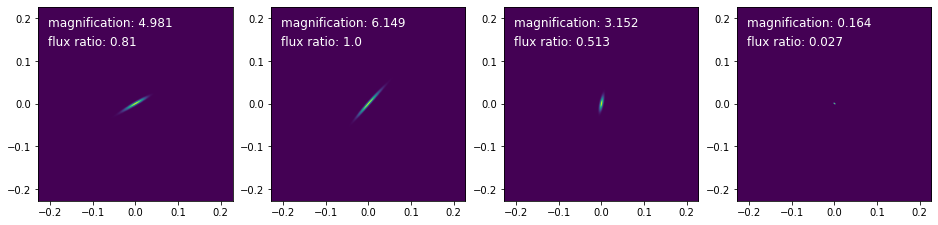

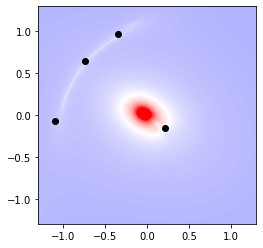

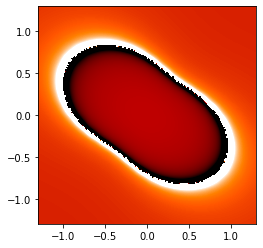

continue
flux ratios data:  [1.1363636363636365, 0.5386363636363636]
flux ratios model:  [1.2195842512374315, 0.6247353751796595]
statistic:  0.1197443548928513
N_kept:  3
N remaining:  1
accepted realizations counter:  3
readout steps:  2
importance weight for sample:  1.0
sample (from realization samples):  [-1.53813301  9.10921499]
realization contains 6 halos.
['log10_sigma_sub', 'log_mc']
realization hyper-parameters:  [-1.53813301  9.10921499]
['source_size_pc']
source/lens parameters:  56.257766401157944
['a_m_3', 'a_m_4', 'd_phi_a3', 'gamma_macro']
macromodel samples:  [-2.42348317e-04  2.41731850e-03  4.15696701e-01  2.08764934e+00]


keyword arguments for realization: 
preset model function:  <function WDM at 0x7fab8b440820>
kwargs preset model:  {'sigma_sub': 0.028964563957896386, 'LOS_normalization': 1.0, 'log_mc': 9.109214987944327, 'log_m_host': 13.3, 'cone_opening_angle_arcsec': 3.8832270661274713}
optimization 1
aperture size (front):  100
aperture size (back):  100
log

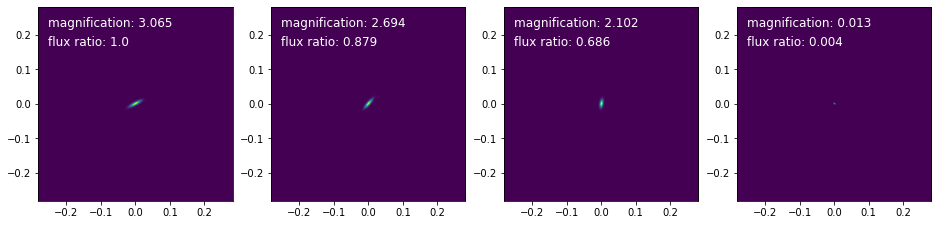

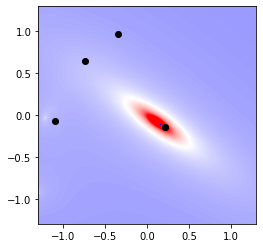

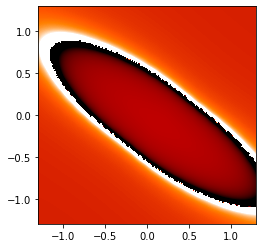

continue
flux ratios data:  [1.1363636363636365, 0.5386363636363636]
flux ratios model:  [0.8699062346816465, 0.6721180716460002]
statistic:  0.29802166579677936
N_kept:  4
N remaining:  0
accepted realizations counter:  4
readout steps:  2
reading out data on this iteration.
final data readout...
writing parameter output to /Users/danielgilman/Code/quadmodel/notebooks/example_inference_output/job_1/parameters.txt
writing flux ratio output to /Users/danielgilman/Code/quadmodel/notebooks/example_inference_output/job_1/fluxes.txt
writing macromodel samples to /Users/danielgilman/Code/quadmodel/notebooks/example_inference_output/job_1/macromodel_samples.txt
writing kappa/gamma statistics to /Users/danielgilman/Code/quadmodel/notebooks/example_inference_output/job_1/kappa_gamma_statistics.txt
writing curved arc statistics to /Users/danielgilman/Code/quadmodel/notebooks/example_inference_output/job_1/curvedarc_statistics.txt
writing curved arc statistics to /Users/danielgilman/Code/quadmode

In [3]:
forward_model(output_path, job_index, lens_data, n_keep, realization_priors, 
              macromodel_priors, tolerance=summary_statistic_tolerance, 
                  verbose=True, test_mode=True, save_realizations=True, 
             readout_kappagamma_statistics=True, readout_curvedarc_statistics=True, 
             readout_macromodel_samples=True, n_macro=4, diff_scale_list=[0.0001, 0.025, 0.1])

### Examine the output

The simulation output includes files named fluxes.txt, parameters.txt, and simulation_output_1, simulation_output_2, etc.

In [6]:
f = open(output_path + 'job_'+str(job_index)+'/parameters.txt', 'r')
param_names = f.readlines()[0]
print('PARAMETER NAMES:')
print(param_names)
f.close()

accepeted_parameters = np.loadtxt(output_path + 'job_'+str(job_index)+'/parameters.txt', skiprows=1)
print('ACCEPTED PARAMETERS:')
print(accepeted_parameters)
# the first set of parameters are the ones specified in kwargs_realization (see cell #2), the rest are the source size, 
# macromodel parameters, and the last parameter is the summary statistic

accepeted_mags = np.loadtxt(output_path + 'job_'+str(job_index)+'/fluxes.txt')
print('\nACCEPTED MAGNIFICATIONS:')
print(accepeted_mags)

kappa_gamma_statistics = np.loadtxt(output_path + 'job_'+str(job_index)+'/kappa_gamma_statistics.txt', skiprows=1)
print('\nCONVERGENCE AND SHEAR: ')
print(kappa_gamma_statistics)
print(kappa_gamma_statistics.shape)

curved_arc_statistics = np.loadtxt(output_path + 'job_'+str(job_index)+'/curvedarc_statistics.txt', skiprows=1)
print('\nCURVED ARC STATISTICS: ')
print(curved_arc_statistics)
print(curved_arc_statistics.shape)

PARAMETER NAMES:
log10_sigma_sub log_mc source_size_pc a_m_3 a_m_4 d_phi_a3 gamma_macro summary_statistic importance_weight 

ACCEPTED PARAMETERS:
[[-1.9782330e+00  9.8385050e+00  3.1336820e+01  5.6940000e-03
   6.1450000e-03  5.8562400e-01  2.0330790e+00  1.1610300e-01
   1.0000000e+00]
 [-1.7535340e+00  8.0835450e+00  4.9780627e+01 -4.1300000e-04
  -7.3570000e-03  7.9406200e-01  2.0729100e+00  6.9929000e-02
   1.0000000e+00]
 [-1.9459980e+00  9.2467680e+00  4.5505645e+01  6.9600000e-04
   2.7310000e-03  3.0019100e-01  2.1985330e+00  1.1974400e-01
   1.0000000e+00]
 [-1.5381330e+00  9.1092150e+00  5.6257766e+01 -2.4200000e-04
   2.4170000e-03  4.1569700e-01  2.0876490e+00  2.9802200e-01
   1.0000000e+00]]

ACCEPTED MAGNIFICATIONS:
[[0.893927 1.       0.577755 0.019462]
 [0.845429 1.       0.513455 0.045543]
 [0.810271 1.       0.512733 0.026736]
 [1.       0.878991 0.685977 0.00434 ]]

CONVERGENCE AND SHEAR: 
[[ 0.340885  0.499211  0.317246  4.623932  0.340931  0.499079  0.317311
   4

### Visualize accepeted realizations

The pickeled classes in simulation_output allow you to visualize the accepeted realizations

In [15]:
import pickle
f = open(output_path + 'job_'+str(job_index)+'/simulation_output_2', 'rb')
simulation_output = pickle.load(f)
f.close()
x_image, y_image = simulation_output.data.x, simulation_output.data.y
lens_system = simulation_output.lens_system

npix = 150
rminmax = 1.25
_r = np.linspace(-rminmax, rminmax, npix)
xx, yy = np.meshgrid(_r, _r)
shape0 = xx.shape
lensmodel, kwargs_lens = lens_system.get_lensmodel()
lensmodel_macro, kwargs_macro = lens_system.get_macro_lensmodel(4)

kappa = lensmodel.kappa(xx.ravel(), yy.ravel(), kwargs_lens).reshape(shape0)
kappa_macro = lensmodel_macro.kappa(xx.ravel(), yy.ravel(), kwargs_lens).reshape(shape0)

# print(kappa)
# print(kappa_macro)

In [ ]:
import matplotlib.pyplot as plt

vminmax = 0.05
kappa_subs_nonlinear = kappa - kappa_macro
extent = [-rminmax, rminmax, -rminmax, rminmax]

fig = plt.figure(1)
fig.set_size_inches(8, 8)
plt.imshow(kappa_subs_nonlinear, vmin=-vminmax, vmax=vminmax, origin='lower', cmap='bwr', 
           extent=extent)
plt.scatter(x_image, y_image, color='k')
plt.show()

source_size_pc = accepeted_parameters[0, 4]
#lens_system.plot_images(x_image, y_image, source_size_pc, lensmodel, kwargs_lens)

### Check convergence, shear, and curved arc properties

In [87]:
from lenstronomy.LensModel.lens_model_extensions import LensModelExtensions
#from quadmodel.Solvers.light_fit_util import split_by_image_curvedarc, split_by_scale_curvedarc

def split_curved_arc_params(params, keep_scale=1):
    rs_scale1 = params[:,0:4]
    rs_scale2 = params[:,4:8]
    rs_scale3 = params[:,8:12]
    ts_scale1 = params[:,12:16]
    ts_scale2 = params[:,16:20]
    ts_scale3 = params[:,20:24]
    curv_scale1 = params[:,24:28]
    curv_scale2 = params[:,28:32]
    curv_scale3 = params[:,32:36]
    dir_scale1 = params[:,36:40]
    dir_scale2 = params[:,40:44]
    dir_scale3 = params[:,44:48]
    dtandtan_scale1 = params[:,48:52]
    dtandtan_scale2 = params[:,52:56]
    dtandtan_scale3 = params[:,56:60]
    if keep_scale==1:
        rs = rs_scale1
        ts = ts_scale1
        curv = curv_scale1
        direction = dir_scale1
        dtan_dtan = dtandtan_scale1
    elif keep_scale==2:
        rs = rs_scale2
        ts = ts_scale2
        curv = curv_scale2
        direction = dir_scale2
        dtan_dtan = dtandtan_scale2
    elif keep_scale==3:
        rs = rs_scale3
        ts = ts_scale3
        curv = curv_scale3
        direction = dir_scale3
        dtan_dtan = dtandtan_scale3
    image1 = np.array([rs[0], ts[0], curv[0], direction[0], dtan_dtan[0]])
    image2 = np.array([rs[1], ts[1], curv[1], direction[1], dtan_dtan[1]])
    image3 = np.array([rs[2], ts[2], curv[2], direction[2], dtan_dtan[2]])
    image4 = np.array([rs[3], ts[3], curv[3], direction[3], dtan_dtan[3]])
    return image1.T, image2.T, image3.T, image4.T
        
simulation_index = 1
f = open(output_path + 'job_'+str(job_index)+'/simulation_output_'+str(simulation_index), 'rb')
simulation_output = pickle.load(f)
f.close()
x_image, y_image = simulation_output.data.x, simulation_output.data.y
lens_system = simulation_output.lens_system
lensmodel, kwargs_lens = lens_system.get_lensmodel()

ext = LensModelExtensions(lensmodel)

kwargs_arc_image1 = ext.curved_arc_estimate(x_image[0], y_image[0], kwargs_lens, tan_diff=True)
kwargs_arc_image2 = ext.curved_arc_estimate(x_image[1], y_image[1], kwargs_lens, tan_diff=True)
kwargs_arc_image3 = ext.curved_arc_estimate(x_image[2], y_image[2], kwargs_lens, tan_diff=True)
kwargs_arc_image4 = ext.curved_arc_estimate(x_image[3], y_image[3], kwargs_lens, tan_diff=True)

image1, image2, image3, image4 = split_curved_arc_params(curved_arc_statistics)
print(image1[0,:])
print(kwargs_arc_image1)

[0.883556 5.363661 0.616742 2.075031 3.778295]
{'radial_stretch': 0.8835555569385148, 'tangential_stretch': 5.363652525980767, 'curvature': 0.6168482210436003, 'direction': 2.0750309298876615, 'center_x': -0.3425250652559897, 'center_y': 0.9643059504897872, 'dtan_dtan': 3.794340795619781}
